In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

!pip install -q tensorflow-hub
!pip install -q tensorflow-datasets
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


In [2]:
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

In [3]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: id=219, shape=(10,), dtype=string, numpy=
array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story p

In [4]:
train_labels_batch

<tf.Tensor: id=220, shape=(10,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])>

In [5]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",dtype=tf.string, input_shape=[],trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: id=402, shape=(3, 128), dtype=float32, numpy=
array([[ 1.78428471e+00, -2.29856372e-01,  2.45664164e-01,
         6.84022367e-01, -1.29306912e-01, -1.57380581e-01,
        -1.81604568e-02, -3.73616189e-01, -1.86627433e-01,
         2.31135096e-02,  2.92425722e-01, -4.98053074e-01,
        -4.21140671e-01, -4.68299031e-01, -3.36686820e-01,
        -1.38489604e-01, -3.70901823e-01, -1.46785565e-02,
        -4.20534164e-01,  1.43151474e+00,  1.00796312e-01,
         4.05581176e-01, -8.53958651e-02, -1.26951560e-01,
        -1.08419672e-01, -3.50219727e-01,  4.06883471e-02,
        -1.95807740e-01, -1.16975710e-01, -5.78830671e-03,
         9.03800651e-02, -9.08162072e-02, -8.68640095e-03,
        -1.64070018e-02,  3.24384898e-01, -9.46734697e-02,
        -1.63240522e-01, -4.01422143e-01, -4.99349594e-01,
         5.78139901e-01, -1.41224876e-01,  3.35231982e-02,
        -1.43409833e-01, -1.45958960e-01,  4.64950085e-01,
         1.25476301e-01, -1.26240194e-01, -5.81108630e-01

In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                32        
Total params: 124,644,801
Trainable params: 124,644,801
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [1]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)


Epoch 1/20
30/30 [==============================] - 71s 2s/step - loss: 0.5998 - accuracy: 0.879 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 64s 2s/step - loss: 0.4132 - accuracy: 0.891 - val_loss: 0.3633 - val_accuracy: 0.891
Epoch 3/20
30/30 [==============================] - 71s 2s/step - loss: 0.5910 - accuracy: 0.892 - val_loss: 0.3633 - val_accuracy: 0.892
Epoch 4/20
30/30 [==============================] - 64s 2s/step - loss: 0.5132 - accuracy: 0.8572 - val_loss: 0.3635 - val_accuracy: 0.8572
Epoch 5/20
30/30 [==============================] - 71s 2s/step - loss: 0.5988 - accuracy: 0.861 - val_loss: 0.3633 - val_accuracy: 0.861
Epoch 6/20
30/30 [==============================] - 64s 2s/step - loss: 0.5122 - accuracy: 0.8572 - val_loss: 0.3633 - val_accuracy: 0.8584
Epoch 7/20
30/30 [==============================] - 71s 2s/step - loss: 0.5128 - accuracy: 0.8109 - val_loss: 0.3633 - val_accuracy: 0.8109
Epoch 8/20
30/30 [=

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

98/98 - 4s - loss: 0.523 - accuracy: 0.909
loss: 0.523
accuracy: 0.909


In [15]:
import pandas as pd
Iphone = pd.read_csv("Iphone.csv", sep="\t")
Iphone.columns = ['A']
type(Iphone.get("A"))

pandas.core.series.Series

In [16]:
sentOld= model.predict(Iphone.get("A"))
pos = 0
neg = 0
for i in range(len(sentOld)): 
    if sentOld[i] > 0.5: 
        pos = pos + 1
    elif sentOld[i] < 0.5: 
        neg = neg + 1
print(pos)
print(neg)

305
413


In [17]:
import pandas as pd2
Iphone2 = pd2.read_csv("IphoneRecent.csv", sep="\t")
Iphone2.columns = ['B']
type(Iphone2.get("B"))

pandas.core.series.Series

In [18]:
sentNew = model.predict(Iphone2.get("B"))
neg2 = 0
pos2 = 0
for i in range(len(sentNew)):
    if sentNew[i] > 0.5:
        pos2 = pos2 + 1
    elif sentNew[i] < 0.5:
        neg2 = neg2 + 1
print(pos2)
print(neg2)

1004
948


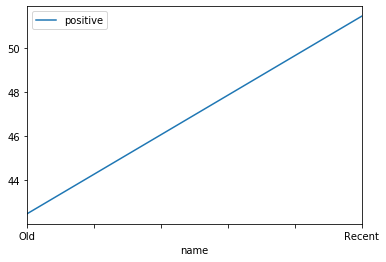

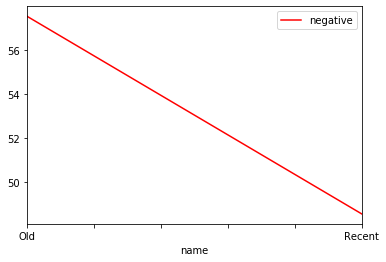

In [20]:
posOldPer = (pos/(pos+neg))*100 
negOldPer = (neg/(pos+neg))*100 
posNewPer = (pos2/(pos2+neg2))*100 
negNewPer = (neg2/(pos2+neg2))*100 
import matplotlib.pyplot as plt
import pandas as pd
Plotdf = pd.DataFrame({
    'name':['Old', 'Recent'],
    'positive': [posOldPer, posNewPer],
    'negative': [negOldPer, negNewPer]
})

Plotdf.plot(kind='line',x='name',y='positive')
Plotdf.plot(kind='line',x='name',y='negative', color='red')

plt.show()